# Table of Contents

* [Introduction](#Introduction)
* [1. EDA & Data Transformation](#1.-EDA-&-Data-Transformation)
  * [1.1. Checking missing values](#1.1.-Checking-missing-values)
  * [1.2. Measurement Scales](#1.2.-Measurement-Scales)
  * [1.3. Nominal Data](#1.3.-Nominal-Data)
    * [1.3.1. Dummifying](#1.3.1.-Dummifying)
    * [1.3.2. Binarizaiton](#1.3.2.-Binarizaiton)
    * [1.3.3. Counts](#1.3.3.-Counts)
    * [1.3.4. Date Extraction](#1.3.4.-Date-Extraction)
  * [1.4. Nominal Data Transformation](#1.4.-Nominal-Data-Transformation)
    * [1.4.1. Feature Selector](#1.4.1.-Feature-Selector)
    * [1.4.2. Dictionary Vectorizer](#1.4.2.-Dictionary-Vectorizer)
    * [1.4.3. Top Features](#1.4.3.-Top-Features)
    * [1.4.4. Sum Transformer](#1.4.4.-Sum-Transformer)
    * [1.4.5. Binarizer](#1.4.5.-Binarizer)
    * [1.4.6. Date Transformer](#1.4.6.-Date-Transformer)
    * [1.4.7. Item Counter](#1.4.7.-Item-Counter)
  * [1.5. Numerical data](#1.5.-Numerical-data)
* [2. Building a Pipeline](#2.-Building-a-Pipeline)
  * [2.1. Feature Union](#2.1.-Feature-Union)
  * [2.2. Model Selection](#2.2.-Model-Selection)
* [Conclusion](#Conclusion)
* [References](#References)

# Introduction

In this kernel, I'll focus on feature engineering using `sklearn pipelines`. 

What are `pipelines`?. In short `pipelines` are ways to organize your transformers in a manageable, linear way. I'd like to think about each `pipeline` as a list of step-by-step instructions to transform your data. More information, you can find in [sklearn.Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) documentation.

I noticed once you will get used to them, you can quickly and easily deal with data imputation and transformation. Moreover, it prevents data leakage and you only write transformer once - you can easily fit (and if needed transform as well) it on the training dataset and use it on the test set.

Here are some resources I find useful to explain what `pipelines` are and how to use them:
* [Kevin Goetsch - Deploying Machine Learning using sklearn pipelines](https://www.youtube.com/watch?v=URdnFlZnlaE)
* [Julie Michelman - Pandas, Pipelines, and Custom Transformers](https://www.youtube.com/watch?v=BFaadIqWlAg)

As this is my first data science project I'm aiming to establish a clear and consistent workflow for future projects, so I'd say this notebook is rather directed towards beginners, looking for an inspiration/reference.

<br/><br/>

**The goal of the project is to predict revenue of a movie using TMDB 5000 Movie Dataset.**

<br/><br/>

Let's start with imports and train/test split!

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
import seaborn as sns
import matplotlib.pyplot as plt

import random
random.seed(42)

In [2]:
credits = pd.read_csv('tmdb_5000_credits.csv', index_col='movie_id')
movies = pd.read_csv('tmdb_5000_movies.csv', index_col='id')

data = pd.merge(movies, credits)
print(data.shape)

data = data.loc[data['revenue'] != 0]
data['revenue'].dropna(inplace=True)
print(data.shape)


X_train, X_test, y_train, y_test = train_test_split(data.drop(['revenue'], axis=1), data['revenue']) 

Exploratory = X_train.copy() # I'm using the copy of the data (not the view!) just in case, not to mess with the original dataset.

(4809, 21)
(3379, 21)


I'm dropping observations where target data (*revenue*) is missing, so I'm only left with data I can use for predictions.

# 1. EDA & Data Transformation

Exploratory Data Analysis (EDA) and Data Transformation are often thought as a cycle (EDA &rarr; Transform &rarr; EDA etc.), I'll start with **checking missing values**, then I'll get to transforming nominal data, and later on I'll do EDA on numeric data. As the nominal data is quite entangled (efter extraction reasembles text corpus) in this dataset, I'll omit the EDA of this part. 

## 1.1. Checking missing values

In [3]:
nan_percent = Exploratory.isna().mean()*100
nan_count = Exploratory.isna().sum()
pd.concat([nan_count.rename('missing_count'), nan_percent.round().rename('missing_percent')], axis=1)

,missing_count,missing_percent
budget,0,0.0
genres,0,0.0
homepage,1491,59.0
keywords,0,0.0
original_language,0,0.0
original_title,0,0.0
overview,0,0.0
popularity,0,0.0
production_companies,0,0.0
production_countries,0,0.0


Luckily only two features have any missing values.

Let's think if we really need all the features we have so far. I believe the *title* won't tell us much about future revenue and we already have a similar feature to *overview* and *tagline*, which is *keywords*, so let's get rid of those.

In [4]:
columns_to_drop = ['original_title', 'overview', 'tagline', 'title']
# original_title/title - not informative
# overview/tagline - similar features may be found in 'keywords'

Exploratory = Exploratory.drop(columns_to_drop, axis=1)

As I find *tagline* uninformative, I got rid of it completely, therefore we're left with only *homepage* column as the only feature having missing values. As the *homepage* feature has about 60% of missing data, we can, later on, binarize this column on the criteria whether or not a movie has a homepage (**True** if a movie has a homepage **False** if a homepage is missing).

In [5]:
dtypes_description = pd.Series(['ratio', 'nominal', 'nominal', 'nominal', 'nominal', 'ratio', 'nominal', 'nominal', \
                     'interval', 'ratio', 'nominal', 'nominal', 'ratio', 'ratio', 'nominal', 'nominal'], \
                     index=Exploratory.dtypes.index)

pd.concat([Exploratory.dtypes.rename('dtype'), Exploratory.iloc[420].rename('example'), dtypes_description.rename('description')], axis=1)

,dtype,example,description
budget,int64,4500000,ratio
genres,object,"[{""id"": 53, ""name"": ""Thriller""}, {""id"": 28, ""n...",nominal
homepage,object,NaN,nominal
keywords,object,"[{""id"": 2227, ""name"": ""evacuation""}, {""id"": 60...",nominal
original_language,object,hi,nominal
popularity,float64,2.55156,ratio
production_companies,object,"[{""name"": ""T-Series"", ""id"": 3522}, {""name"": ""H...",nominal
production_countries,object,"[{""iso_3166_1"": ""IN"", ""name"": ""India""}]",nominal
release_date,object,2016-01-22,interval
runtime,float64,126,ratio


## 1.2. Measurement Scales

This overview of a random sample shows us what kind of data we are dealing with. Six columns are a list of dictionaries (genres, keywords, production_companies, production_countries, spoken_languages, cast, and crew). We also have five numerical columns (budget, popularity, runtime, vote_average, and vote_count) and other string columns, which are labeled as an object - original_language, release_date, and status.

You probably noticed I labeled each column with its type. Each type refers to the Measurement Scale. In short, these scales refer to the quality of the data, where:
* **ratio** - it's a numerical scale with absolute zero, for example, age;
* **interval** - it's also a numerical scale, but without absolute zero, as it is the case for Fahrenheit scale. For temperature measurement Kelvin would be a ratio scale;
* **ordinal** - which is not present in our data set, refers to measurements you can put in order, but you cannot tell the quantitive difference between adjacent measurements;
* **nominal** - in this scale each item is treated as having the same quality, for example, city names;

More detailed overview of measurement scales you can find in [Multivariate Data Analysis](https://www.pearson.com/us/higher-education/program/Hair-Multivariate-Data-Analysis-7th-Edition/PGM263675.html) book.

## 1.3. Nominal Data

Let's now try to come up with a plan to deal with our nominal data. As the data comes with multiple different forms, we have a wide field of options on how to deal with it.

In [6]:
Exploratory[['genres', 'spoken_languages', 'crew']].head()

,genres,spoken_languages,crew
105,"[{""id"": 14, ""name"": ""Fantasy""}]","[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""credit_id"": ""54e522edc3a3682aff000521"", ""de..."
2659,"[{""id"": 16, ""name"": ""Animation""}, {""id"": 12, ""...","[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""credit_id"": ""52fe4d1fc3a36847f824fbfd"", ""de..."
2628,"[{""id"": 53, ""name"": ""Thriller""}]","[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...","[{""credit_id"": ""52fe45c99251416c9103e539"", ""de..."
2892,"[{""id"": 18, ""name"": ""Drama""}, {""id"": 10749, ""n...","[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...","[{""credit_id"": ""52fe46bb9251416c9105dcad"", ""de..."
3490,"[{""id"": 28, ""name"": ""Action""}]","[{""iso_639_1"": ""en"", ""name"": ""English""}]","[{""credit_id"": ""52fe467e9251416c7507a031"", ""de..."


### 1.3.1. Dummifying

For most of the data coming in the form of a list of dictionaries, we'll simply extract fields that interest us, and dummify them. In some cases, to avoid sparsification, we'll choose some fraction of the most occurring values.

**Columns to dummify**:

*genres, keywords production_companies, production_countries, crew*

In [7]:
Exploratory[['homepage', 'original_language', 'status']].head()

,homepage,original_language,status
105,http://movies.disney.com/alice-through-the-loo...,en,Released
2659,http://www.triggerfish.co.za/khumba/,en,Released
2628,http://in-crowd.warnerbros.com/,en,Released
2892,http://www.ondinefilm.com,en,Released
3490,NaN,en,Released


### 1.3.2. Binarizaiton

Here we'll simple binarize the data - the column will get label `True` or `False` (or `1` or `0`) on certain, established condition.

**Columns to binarize**:

*homepage, original_language, status, spoken_languages*

In [8]:
Exploratory['cast'].head().to_frame()

,cast
105,"[{""cast_id"": 3, ""character"": ""Mad Hatter"", ""cr..."
2659,"[{""cast_id"": 4, ""character"": ""Khumba (voice)"",..."
2628,"[{""cast_id"": 1, ""character"": ""Brittany"", ""cred..."
2892,"[{""cast_id"": 1, ""character"": ""Syracuse"", ""cred..."
3490,"[{""cast_id"": 1, ""character"": ""Louis Stevens"", ..."


### 1.3.3. Counts

As an example, we'll count how many popular actors (having most appearances) are cast in a movie. Perhaps the more of them playing in one movie, the higher is the revenue...

In [9]:
Exploratory['release_date'].head().to_frame()

,release_date
105,2016-05-25
2659,2013-07-18
2628,2000-07-19
2892,2009-09-14
3490,1993-08-27


### 1.3.4. Date Extraction

In this data set, we have *release_date* in a string form. Probably it will be better if we extract from it: year, month and day, and dummify the latter two.

# 1.4. Nominal Data Transformation

Let's now get to writing actual transformers to, well, transform the data. First, we need to import certain classes our custom transformers need to inherit from.

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin

### 1.4.1. Feature Selector

This transformer is really straightforward - it simply takes the name of the column we want to extract and if we use it, it will 'spit out' the data column of our Data Frame.

In [11]:
class FeatureSelector(BaseEstimator, TransformerMixin):

    def __init__(self, feature_names):
        self.feature_names = feature_names
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return X[self.feature_names]

In [12]:
prod_companies = FeatureSelector('production_companies').fit_transform(Exploratory)
prod_companies.to_frame().head()

,production_companies
105,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""..."
2659,"[{""name"": ""Triggerfish Animation"", ""id"": 33805}]"
2628,"[{""name"": ""Morgan Creek Productions"", ""id"": 10..."
2892,"[{""name"": ""Octagon Films"", ""id"": 1266}, {""name..."
3490,"[{""name"": ""Davis Films"", ""id"": 14175}, {""name""..."


### 1.4.2. Dictionary Vectorizer

This one is a bit more complex. It's role is to:
* 1<sup>st</sup> - extract values from dictionaries,
* 2<sup>nd</sup> - join them in one string,
* 3<sup>rd</sup> - dummify it using `sklearn` Count Vectorizer.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import re

def extract_items(list_, key, all_=True):
    sub = lambda x: re.sub(r'[^A-Za-z0-9]', '_', x)
    if all_:
        target = []
        for dict_ in eval(list_):
            target.append(sub(dict_[key].strip()))
        return ' '.join(target)
    elif not eval(list_):
        return 'no_data'
    else:
        return sub(eval(list_)[0][key].strip())

class DictionaryVectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, key, all_=True):
        self.key = key
        self.all = all_
    
    def fit(self, X, y=None):
        genres = X.apply(lambda x: extract_items(x, self.key, self.all))
        self.vectorizer = CountVectorizer().fit(genres)        
        self.columns = self.vectorizer.get_feature_names()
        return self
        
    def transform(self, X):
        genres = X.apply(lambda x: extract_items(x, self.key))
        data = self.vectorizer.transform(genres)
        return pd.DataFrame(data.toarray(), columns=self.vectorizer.get_feature_names(), index=X.index)

In [14]:
prod_companies_vectorized = DictionaryVectorizer('name').fit_transform(prod_companies)
prod_companies_vectorized.head()

,100_bares,1019_entertainment,10th_hole_productions,120_films,120db_films,1492_pictures,16_block_productions,1821_pictures,1984_private_defense_contractors,19_entertainment,...,zhejiang_huace_film___tv,zide_perry_productions,zininsa_film_production,zip_films,zippcast_films,zoetrope_studios,zookeeper_productions,zucker_netter_productions,zupnik_cinema_group_ii,zwart_arbeid
105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.4.3. Top Features

This transformer expects dummified data set and extract most popular features.

In [15]:
class TopFeatures(BaseEstimator, TransformerMixin):
    
    def __init__(self, percent):
        if percent > 100:
            self.percent = 100
        else:
            self.percent = percent
    
    def fit(self, X, y=None):
        counts = X.sum().sort_values(ascending=False)
        index_ = int(counts.shape[0]*self.percent/100)
        self.columns = counts[:index_].index
        return self
    
    def transform(self, X):
        return X[self.columns]

In [16]:
top_companies = TopFeatures(1).fit_transform(prod_companies_vectorized)
top_companies.head()

,warner_bros_,paramount_pictures,universal_pictures,twentieth_century_fox_film_corporation,columbia_pictures,new_line_cinema,metro_goldwyn_mayer__mgm_,relativity_media,walt_disney_pictures,columbia_pictures_corporation,...,fox_searchlight_pictures,summit_entertainment,dune_entertainment,fox_2000_pictures,tristar_pictures,dimension_films,legendary_pictures,the_weinstein_company,dreamworks_animation,new_regency_pictures
105,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2659,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3490,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.4.4. Sum Transformer

Sum Transformer simply computes a sum across given features. We'll use it on our sparse data (after dummification).

In [17]:
class SumTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, series_name):
        self.series_name = series_name
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return X.sum(axis=1).to_frame(self.series_name)

In [18]:
companies_count = SumTransformer('companies_count').fit_transform(prod_companies_vectorized)
companies_count.head()

,companies_count
105,5
2659,1
2628,1
2892,6
3490,2


### 1.4.5. Binarizer

Biniarizer takes as an input function that decides whether or not label value as `True` or `False`.

In [19]:
class Binarizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, condition, name):
        self.condition = condition
        self.name = name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda x : int(self.condition(x))).to_frame(self.name)

In [20]:
missing_homepage = Binarizer(lambda x: isinstance(x, float), 'missing_homepage').fit_transform(Exploratory['homepage'])
missing_homepage.head(15)

,missing_homepage
105,0
2659,0
2628,0
2892,0
3490,1
1705,1
91,0
2777,1
1357,0
2737,1


### 1.4.6. Date Transformer

As mentioned earlier, this transformer takes a date in string format and extract values of interest.

In [21]:
from datetime import datetime

def get_year(date):
    return datetime.strptime(date, '%Y-%m-%d').year

def get_month(date):
    return datetime.strptime(date, '%Y-%m-%d').strftime('%b')

def get_weekday(date):
    return datetime.strptime(date, '%Y-%m-%d').strftime('%a')

class DateTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        year = X.apply(get_year).rename('year')
        month = pd.get_dummies(X.apply(get_month))
        day = pd.get_dummies(X.apply(get_weekday))
        return pd.concat([year, month, day], axis=1)        

In [22]:
date = DateTransformer().fit_transform(Exploratory['release_date'])
date.head()

,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Fri,Mon,Sat,Sun,Thu,Tue,Wed
105,2016,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2659,2013,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
2628,2000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2892,2009,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3490,1993,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


### 1.4.7. Item Counter

Item Counter counts how many items are in a list.

In [23]:
def get_list_len(list_):
    return len(eval(list_))

class ItemCounter(BaseEstimator, TransformerMixin):
        
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return X.apply(lambda x: int(get_list_len(x)))

In [24]:
language_count = ItemCounter().fit_transform(Exploratory['spoken_languages'])
language_count.head().to_frame('language_count')

,language_count
105,1
2659,1
2628,2
2892,3
3490,1


## 1.5. Numerical data

Now that we've dealt with nominal data it is time to take care of numerical data. Due to use of our transformers, we have new numerical columns: *year* and *top_cast_count*.

In [25]:
year = DateTransformer().fit_transform(Exploratory['release_date'])['year']
top_cast_count = make_pipeline(FeatureSelector('cast'), DictionaryVectorizer('name'), 
                               TopFeatures(0.25), SumTransformer('top_cast_count')).fit_transform(Exploratory)

In [26]:
notional_to_numeric = pd.concat([year, top_cast_count], axis=1)
notional_to_numeric.head(15)

,year,top_cast_count
105,2016,2
2659,2013,3
2628,2000,0
2892,2009,1
3490,1993,0
1705,2001,1
91,2016,0
2777,2013,1
1357,2008,1
2737,1974,2


Let's take a look if we have any abnormal values in our numerical columns.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000237AB649B80>,
      dtype=object)

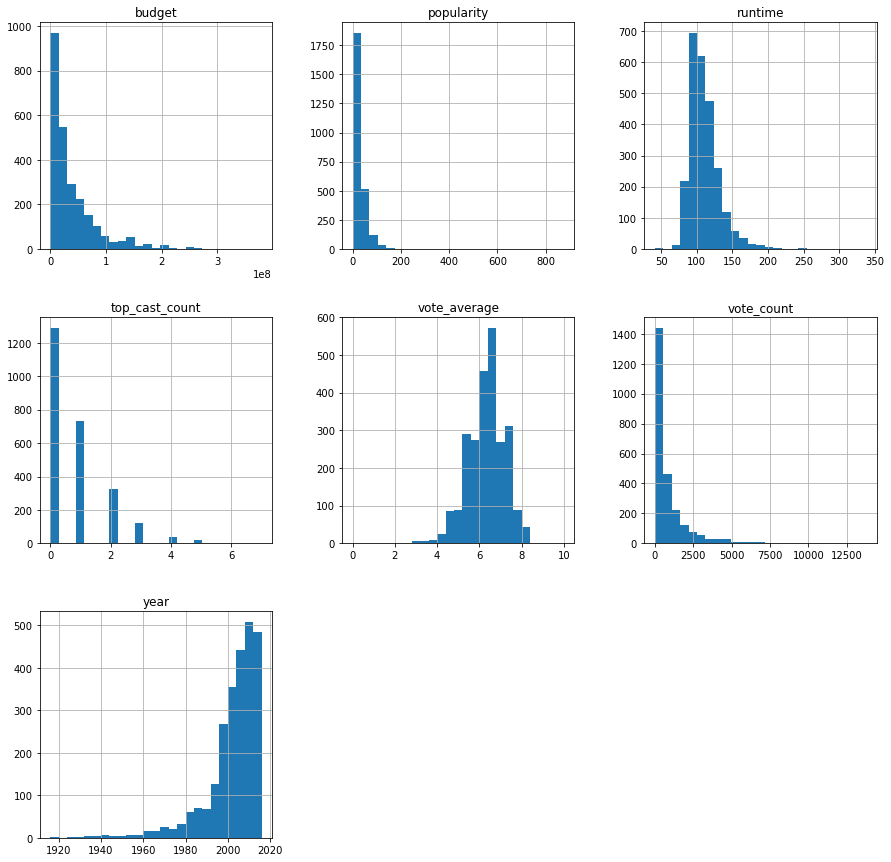

In [27]:
numeric = pd.concat([Exploratory.select_dtypes(['int64', 'float64']), notional_to_numeric], axis=1)

numeric.hist(figsize=(15,15), bins=25)

Seems like everything looks fine, although the data is skewed.

In [28]:
numeric.corr().style.background_gradient(cmap='coolwarm')

,budget,popularity,runtime,vote_average,vote_count,year,top_cast_count
budget,1.000000,0.419787,0.223173,-0.031121,0.539284,0.252124,0.330358
popularity,0.419787,1.000000,0.172551,0.273359,0.741683,0.149055,0.200010
runtime,0.223173,0.172551,1.000000,0.378159,0.249974,-0.150194,0.138071
vote_average,-0.031121,0.273359,0.378159,1.000000,0.370790,-0.178434,0.089854
vote_count,0.539284,0.741683,0.249974,0.370790,1.000000,0.162476,0.256114
year,0.252124,0.149055,-0.150194,-0.178434,0.162476,1.000000,0.139494
top_cast_count,0.330358,0.200010,0.138071,0.089854,0.256114,0.139494,1.000000


We see we have two features (*popularity* and *vote_count*) that are strongly correlated. Let's take a closer look.

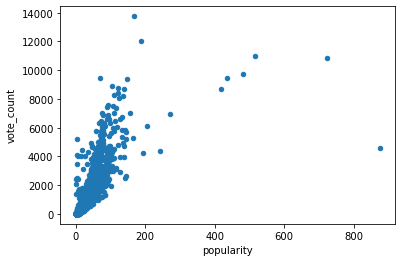

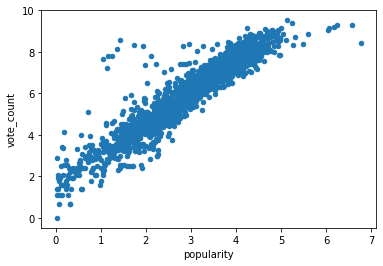

In [29]:
numeric.plot(kind='scatter', x='popularity', y='vote_count')
possible_outliers = Exploratory[Exploratory['popularity'] > 400]

numeric[['popularity', 'vote_count']] = np.log(Exploratory[['popularity', 'vote_count']] + 1)
numeric.plot(kind='scatter', x='popularity', y='vote_count')

We had to take care of heteroscedasticity. Luckily log transformation took care of it. Now we have more or less the same variance of residuals across all values.

We also could notice some outliers. Let's take a look at observations with popularity higher than 400.

In [30]:
possible_outliers

,budget,genres,homepage,keywords,original_language,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,status,vote_average,vote_count,cast,crew
28,150000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.jurassicworld.com/,"[{""id"": 1299, ""name"": ""monster""}, {""id"": 1718,...",en,418.708552,"[{""name"": ""Universal Studios"", ""id"": 13}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-06-09,124.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,6.5,8662,"[{""cast_id"": 10, ""character"": ""Owen Grady"", ""c...","[{""credit_id"": ""52fe4bf7c3a368484e1a0683"", ""de..."
95,165000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 18, ""...",http://www.interstellarmovie.net/,"[{""id"": 83, ""name"": ""saving the world""}, {""id""...",en,724.247784,"[{""name"": ""Paramount Pictures"", ""id"": 4}, {""na...","[{""iso_3166_1"": ""CA"", ""name"": ""Canada""}, {""iso...",2014-11-05,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,8.1,10867,"[{""cast_id"": 9, ""character"": ""Joseph Cooper"", ...","[{""credit_id"": ""52fe4bbf9251416c910e4801"", ""de..."
94,170000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...",http://marvel.com/guardians,"[{""id"": 8828, ""name"": ""marvel comic""}, {""id"": ...",en,481.098624,"[{""name"": ""Marvel Studios"", ""id"": 420}, {""name...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2014-07-30,121.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,7.9,9742,"[{""cast_id"": 1, ""character"": ""Peter Quill / St...","[{""credit_id"": ""538ce329c3a3687155003358"", ""de..."
127,150000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.madmaxmovie.com/,"[{""id"": 2964, ""name"": ""future""}, {""id"": 3713, ...",en,434.278564,"[{""name"": ""Village Roadshow Pictures"", ""id"": 7...","[{""iso_3166_1"": ""AU"", ""name"": ""Australia""}, {""...",2015-05-13,120.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,7.2,9427,"[{""cast_id"": 2, ""character"": ""Max Rockatansky""...","[{""credit_id"": ""577da370c3a36817f8003838"", ""de..."
788,58000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.foxmovies.com/movies/deadpool,"[{""id"": 2095, ""name"": ""anti hero""}, {""id"": 307...",en,514.569956,"[{""name"": ""Twentieth Century Fox Film Corporat...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2016-02-09,108.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,7.4,10995,"[{""cast_id"": 99, ""character"": ""Wade Wilson / D...","[{""credit_id"": ""56c986b2925141172f0068b6"", ""de..."
546,74000000,"[{""id"": 10751, ""name"": ""Family""}, {""id"": 16, ""...",http://www.minionsmovie.com/,"[{""id"": 3487, ""name"": ""assistant""}, {""id"": 179...",en,875.581305,"[{""name"": ""Universal Pictures"", ""id"": 33}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2015-06-17,91.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,6.4,4571,"[{""cast_id"": 22, ""character"": ""Scarlet Overkil...","[{""credit_id"": ""5431b2b10e0a2656e20026c7"", ""de..."


It seems that we're dealing with huge blockbusters here. I guess there's nothing to worry about in this case.

In [31]:
numeric.corr().style.background_gradient(cmap='coolwarm')

,budget,popularity,runtime,vote_average,vote_count,year,top_cast_count
budget,1.000000,0.476130,0.223173,-0.031121,0.498892,0.252124,0.330358
popularity,0.476130,1.000000,0.186255,0.346541,0.934020,0.221014,0.307602
runtime,0.223173,0.186255,1.000000,0.378159,0.195720,-0.150194,0.138071
vote_average,-0.031121,0.346541,0.378159,1.000000,0.379491,-0.178434,0.089854
vote_count,0.498892,0.934020,0.195720,0.379491,1.000000,0.226967,0.314577
year,0.252124,0.221014,-0.150194,-0.178434,0.226967,1.000000,0.139494
top_cast_count,0.330358,0.307602,0.138071,0.089854,0.314577,0.139494,1.000000


After our transformation *vote_count* and *popularity* are even more correlated. It's time to combine them into one feature. I believe taking their average is good enough.

In [32]:
class MeanTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, name):
        self.name = name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.mean(axis=1).to_frame(self.name)

In [33]:
feature_mean = make_pipeline(FeatureSelector(['vote_count', 'popularity']), MeanTransformer('popularity_vote')).fit_transform(Exploratory)
feature_mean.head()

,popularity_vote
105,890.634458
2659,39.229894
2628,7.624623
2892,44.920642
3490,17.205621


In [34]:
numeric['vote_popularity'] = feature_mean
numeric.drop(columns=['popularity', 'vote_count'], inplace=True)

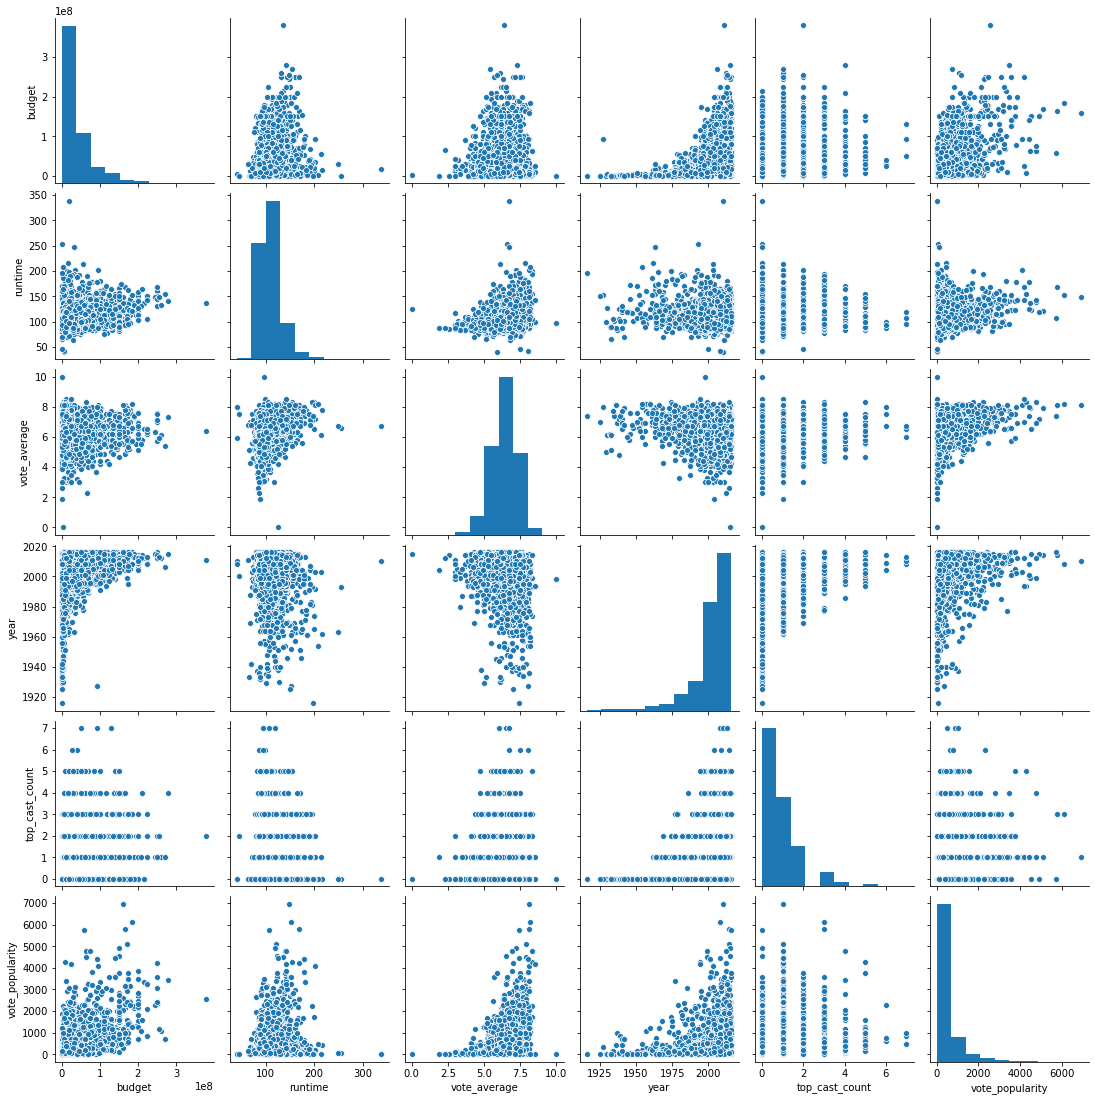

In [35]:
sns.pairplot(numeric)

Now we're left with uncorrelated columns. That's good news as we don't actually count any feature 'twice'.

Maybe we also should transform our target value, so our data fits it better?

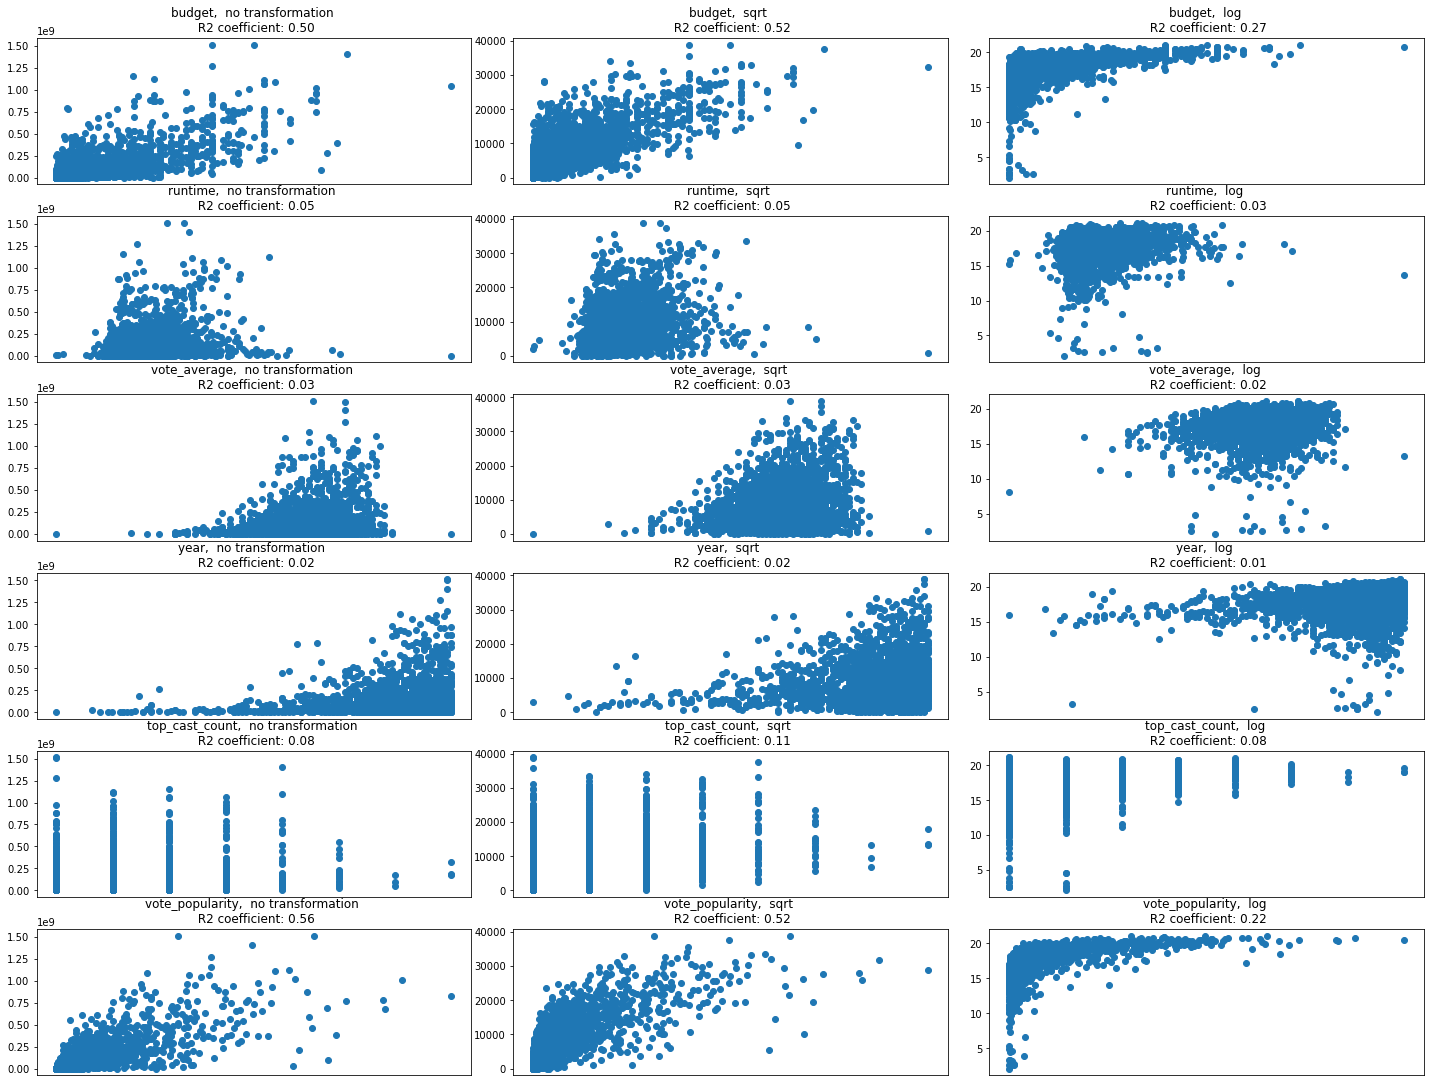

In [36]:
from scipy.stats import pearsonr

transformations = [lambda x: x, np.sqrt, lambda x: np.log(x+1)]
tran_description = [' no transformation', ' sqrt', ' log']
numeric_columns = numeric.columns

fig, axes = plt.subplots(len(numeric_columns), len(transformations), figsize=(20,15))
fig.tight_layout()

for col_idx, col in enumerate(numeric_columns):
    for tran_idx, tran in enumerate(transformations):
        axes[col_idx, tran_idx].scatter(x=numeric[col], y=tran(y_train))
        axes[col_idx, tran_idx].set_xticklabels([])
        axes[col_idx, tran_idx].set_xticks([]) 
        R2 = pearsonr(numeric[col], tran(y_train))[0]**2     
        axes[col_idx, tran_idx].title.set_text(f'{col}, {tran_description[tran_idx]} \n R2 coefficient: {R2:.2f}')
               
plt.show()

Looks like it's not worth the hassle, as we get similar, or lower R2 scores for transformed target data.

# 2. Building a Pipeline

Now that we've dealt with transformers, it's time to combine them into a `pipeline`. What will we do now is we apply our transformers to certain columns and we will combine those transformed data into one `Data Frame`.

## 2.1. Feature Union

To combine the data, we need a class to do this for us. Unfortunately `sklearn` doesn't provide a class that works out of the box with `Pandas`, as we would expect. Instead `sklearn` Feature Union takes `Pandas` Data Frame as input and gave `numpy` array as output and we would like to have `Pandas` Data Frame as output as well. In order to do this, we need to modify `sklearn` source code, so it works as intended. Luckily someone has already done that for us. 

To learn more you can read this [blog post](https://zablo.net/blog/post/pandas-dataframe-in-scikit-learn-feature-union/) by Marcin Zabłocki, along with the [source code](https://github.com/marrrcin/pandas-feature-union/blob/master/pandas_feature_union.py).

In [37]:
from sklearn.externals.joblib import Parallel, delayed
from sklearn.pipeline import FeatureUnion, _fit_transform_one, _transform_one, _name_estimators
from scipy import sparse

import warnings
warnings.filterwarnings('ignore')

class PandasFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X,
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs
    
def make_union(*transformers, **kwargs):
    n_jobs = kwargs.pop('n_jobs', None)
    verbose = kwargs.pop('verbose', False)
    if kwargs:
        # We do not currently support `transformer_weights` as we may want to
        # change its type spec in make_union
        raise TypeError('Unknown keyword arguments: "{}"'
                        .format(list(kwargs.keys())[0]))
    return PandasFeatureUnion(
        _name_estimators(transformers), n_jobs=n_jobs, verbose=verbose)

C:\Users\HP\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Now we just need to apply transformations on each column we intend to work on.

In [38]:
union = make_union(
    make_pipeline(
        FeatureSelector('genres'),
        DictionaryVectorizer('name')
    ),
    make_pipeline(
        FeatureSelector('homepage'),
        Binarizer(lambda x: isinstance(x, float), 'missing_homepage')
    ),
    make_pipeline(
        FeatureSelector('keywords'),
        DictionaryVectorizer('name'),
        TopFeatures(0.5)
    ),
    make_pipeline(
        FeatureSelector('original_language'),
        Binarizer(lambda x: x == 'en', 'en')
    ),
    make_pipeline(
        FeatureSelector('production_companies'),
        DictionaryVectorizer('name'),
        TopFeatures(1)
    ),
    make_pipeline(
        FeatureSelector('production_countries'),
        DictionaryVectorizer('name'),
        TopFeatures(25)
    ),
    make_pipeline(
        FeatureSelector('release_date'),
        DateTransformer()
    ),
    make_pipeline(
        FeatureSelector('spoken_languages'),
        ItemCounter(),
        Binarizer(lambda x: x > 1, 'multilingual')
    ),
    make_pipeline(
        FeatureSelector('original_language'),
        Binarizer(lambda x: x == 'Released', 'Released')
    ),    
    make_pipeline(
        FeatureSelector('cast'),
        DictionaryVectorizer('name'),
        TopFeatures(0.25),
        SumTransformer('top_cast_count')
    ),
    make_pipeline(
        FeatureSelector('crew'),
        DictionaryVectorizer('name', False),
        TopFeatures(1)
    ),
    make_pipeline(
        FeatureSelector(['budget', 'runtime', 'vote_average'])
    ),
    make_pipeline(
        FeatureSelector(['popularity', 'vote_count']),
        MeanTransformer('popularity_vote')
    )
)

What's left now is to fit our pipeline on our training data and transform both train and test data.

In [39]:
union.fit(X_train)

X_train_T = union.transform(X_train)
X_test_T = union.transform(X_test)

print(X_train_T.shape)
print(X_test_T.shape)

(2534, 140)
(845, 140)


And here is our result:

In [40]:
X_train_T.head()

,action,adventure,animation,comedy,crime,documentary,drama,family,fantasy,foreign,...,mary_vernieu,harvey_weinstein,francine_maisler,bob_weinstein,john_williams,danny_elfman,budget,runtime,vote_average,popularity_vote
105,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,170000000,113.0,6.5,890.634458
2659,0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,20000000,85.0,5.8,39.229894
2628,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,15000000,105.0,4.7,7.624623
2892,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,12000000,111.0,6.5,44.920642
3490,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6000000,99.0,6.9,17.205621


## 2.2. Model Selection

Now that we have the data set in the form we wanted, let's fit some models and see wich performs best. `Sklearn` provides very useful utilities for this purpose, namely Grid Search CV. It performs a search of best parameters provided by us, using cross-validation.

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

First, we import models, and then we set parameters for each model in the form of a dictionary.

**Attention!** You can also put models in `pipelines`, but I find this approach a bit messy, so I decided to implement them separately.

In [42]:
lin_params = dict(alpha=np.logspace(1,7,7), normalize=(False, True))
for_params = dict(n_estimators=np.linspace(10,40,4).astype(int), min_samples_split=(2,3), min_samples_leaf=(1,2,3))
gbr_params = dict(n_estimators=np.linspace(100,300,3).astype(int), min_samples_split=(2,3))

In [43]:
ridge_grid = GridSearchCV(Ridge(random_state=42), lin_params, cv=10)
forest_grid = GridSearchCV(RandomForestRegressor(random_state=42), for_params, cv=10)
gbr_grid = GridSearchCV(GradientBoostingRegressor(random_state=42), gbr_params, cv=10)

In [44]:
ridge_grid.fit(X_train_T, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=42,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07]),
                         'normalize': (False, True)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [45]:
forest_grid.fit(X_train_T, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_job

In [ ]:
gbr_grid.fit(X_train_T, y_train)

Now that our models are fit on test data, let's take a look which one performs the best, along with its best parameters chosen by Grid Search.

In [ ]:
print(f'Ridge:\n\t *best params: {ridge_grid.best_params_}\n\t *best score: {ridge_grid.best_score_}')
print(f'Forest:\n\t *best params: {forest_grid.best_params_}\n\t *best score: {forest_grid.best_score_}')
print(f'Gradient Boost:\n\t *best params: {gbr_grid.best_params_}\n\t *best score: {gbr_grid.best_score_}')

Now that we have the best models with the best parameters, let's find out how they perform on test data.

In [ ]:
best_ridge = Ridge(alpha=100, normalize=False)
best_forest = RandomForestRegressor(min_samples_leaf=3, min_samples_split=2, n_estimators=40)
best_gbr = GradientBoostingRegressor(min_samples_split=2, n_estimators=300)

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
best_ridge.fit(X_train_T, y_train)
predicted = best_ridge.predict(X_test_T)

print(f'Ridge test score: {r2_score(y_test, predicted)}')

best_forest.fit(X_train_T, y_train)
predicted = best_forest.predict(X_test_T)

print(f'Random Forest test score: {r2_score(y_test, predicted)}')

best_gbr.fit(X_train_T, y_train)
predicted = best_gbr.predict(X_test_T)

print(f'Gradient Boosted Regressor test score: {r2_score(y_test, predicted)}')

We can also interpret each model by looking at its coefficients.

In [ ]:
ridge_coefs_df = pd.DataFrame(dict(score=best_ridge.coef_, column=X_test_T.columns))
ridge_coefs_df.sort_values(['score'], ascending=False).head(10)

In [ ]:
print(f'Train target variable mean: ${round(y_train.mean()):,}.')

Top coefficients refer to our dummy variables. How can we interpret this? Basically, it shows how a variable differs from a global mean. As the mean of the target variable is counted in hundreds of millions of dollars, no wonder that those values are so high! In addition to those coefficients, Ridge Regression has also regularization terms, that weaken those coefficients.

What about the numerical values?

In [ ]:
ridge_coefs_df.loc[136:]

As we can see, these are much lower. Especially *budget* variable, which we can interpret, that for every dollar invested in a move, we expect about $1.6 revenue.

Both Random Forest and Gradient Boost are subsets of ensemble regressors. In this case, all scores (feature importances) should add up to 1. We can interpret those as the influence of the feature in predicting target value.

In [ ]:
pd.DataFrame(dict(score=best_forest.feature_importances_, column=X_test_T.columns)).sort_values(['score'], ascending=False).head(10)

In [ ]:
pd.DataFrame(dict(score=best_gbr.feature_importances_, column=X_test_T.columns)).sort_values(['score'], ascending=False).head(10)

What we can conclude is that *popularity_vote* and *budget* are the strongest predictors, where the importance of other features is almost insignificant.

# Conclusion

`Pipelines` can be thought of as a useful way to transform and model your data. If used correctly, can save a lot of unnecessary lines of code and unexpected issues, as data leakage. I believe that proficiency in those can make workflow more smooth and the code readable and easy to maintain.

# References
* [PyData Youtube Channel](https://www.youtube.com/user/PyDataTV)
* [Marcin Zabłocki blog](https://zablo.net/)
* [Multivariate Data Analysis - Joseph F. Hair Jr. William C. Black Barry J. Babin Rolph E. Anderson](https://www.pearson.com/us/higher-education/program/Hair-Multivariate-Data-Analysis-7th-Edition/PGM263675.html)
* [Feature Engineering for Machine Learning - Alice Zheng, Amanda Casari](http://shop.oreilly.com/product/0636920049081.do)